In [2]:
import pandas as pd
from core import read_mmseqs_results
from sklearn.metrics import f1_score
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
model_seq_info = pd.read_parquet('../data3/interim/candidate_model_seq_info.pq')
defense_edge_df = pd.read_parquet('../data3/interim/defense_exchangable_edges.pq')

In [4]:
len(defense_edge_df)

4020013

In [5]:
%%time
mmseqs_search_df = read_mmseqs_results('../data3/interim/candiate_seq_mmseqs_self_search.txt')

CPU times: user 29.4 s, sys: 3.8 s, total: 33.2 s
Wall time: 33.5 s


In [6]:
len(mmseqs_search_df)

19047244

In [7]:
%%time
mmseqs_profile_df = read_mmseqs_results('../data3/interim/candidate_mmseqs_profile_out.txt')

CPU times: user 56 s, sys: 6.35 s, total: 1min 2s
Wall time: 1min 2s


In [8]:
len(mmseqs_profile_df)

36384332

In [9]:
%%time
blast_search_df = pd.read_parquet('../data3/interim/model_seq_blast_search.pq')

CPU times: user 22.3 s, sys: 8.68 s, total: 30.9 s
Wall time: 10.2 s


In [10]:
len(blast_search_df)

52573055

In [11]:
gold_standard_edges = mmseqs_profile_df
gold_standard_edges = gold_standard_edges[gold_standard_edges['query'] != gold_standard_edges['target']].copy()
gold_standard_edges = (gold_standard_edges
                      .merge(model_seq_info.rename(columns={'seq_id': 'query'}), 
                             how='inner', on='query')
                      .merge(model_seq_info.rename(columns={'seq_id': 'target'}), 
                             how='inner', on='target', suffixes=('_query', '_target'))
                      .sort_values('bits', ascending=False)
                      .reset_index(drop=True))

In [12]:
def evaluate_filtering(component_df, gold_standard_edges=gold_standard_edges, 
                       model_seq_info=model_seq_info):
    merged_gold_standard_edges = (gold_standard_edges
                                  .merge(component_df.rename(columns={'seq_id': 'query'}), 
                                         how='inner', on='query')
                                  .merge(component_df.rename(columns={'seq_id': 'target'}), 
                                         how='inner', on='target', 
                                         suffixes=('_query', '_target')))
    filtered_gold_standard_edges = merged_gold_standard_edges[
        ~(merged_gold_standard_edges['component_query'] == merged_gold_standard_edges['component_target'])]
    top_gold_standard_edges = (filtered_gold_standard_edges
                               .groupby('query')
                               .head(1))
    eval_df = (model_seq_info
               .merge(top_gold_standard_edges[['query', 'defensive_target']]
                      .rename(columns={'query': 'seq_id'}), 
                      how='left', on='seq_id'))
    np.random.seed(7)
    eval_df.loc[eval_df['defensive_target'].isna(), 'defensive_target'] = np.random.choice(
        [True, False], size=eval_df['defensive_target'].isna().sum())
    eval_df['defensive_target'] = eval_df['defensive_target'].astype(bool)
    f1 = f1_score(eval_df['defensive'], eval_df['defensive_target'])
    return f1
    

In [13]:
cov_cutoffs = [0.5, 0.8]
identity_cutoffs = [0.3, 0.5, 0.7]


In [14]:
def get_components(edge_df, source, target, all_nodes):
    G = nx.from_pandas_edgelist(edge_df, source, target)
    nodes = list(G.nodes)
    missing_nodes = all_nodes[~all_nodes.isin(nodes)].to_list()
    G.add_nodes_from(missing_nodes)
    components = nx.connected_components(G)
    component_list = []
    for i, comp in enumerate(components):
        subgraph = G.subgraph(comp)
        for name in comp:
            component_list.append({'seq_id': name, 
                                   'component': i})
    component_df = pd.DataFrame(component_list)
    largest_component = component_df['component'].value_counts().to_list()[0]
    return largest_component, component_df
    

In [15]:
defense_seqs = model_seq_info.query('defensive')['seq_id']
background_seqs = model_seq_info.query('~defensive')['seq_id']

In [16]:
unfiltered_largest_defense, unfiltered_component_df = get_components(defense_edge_df, 'seq_id_x', 'seq_id_y', 
                                                                     model_seq_info['seq_id'])
unfiltered_largest_defense

1363

In [17]:
evaluate_filtering(unfiltered_component_df)

0.6249637995945555

In [18]:
%%time
method_dict = {'MMseqs profile': mmseqs_profile_df,
               'MMseqs search': mmseqs_search_df, 
               'BLAST': blast_search_df}
result_list = list()
for method, method_df in method_dict.items():
    print(method)
    merged_method_df = (method_df
                        .merge(model_seq_info[['seq_id', 'defensive']]
                               .rename(columns={'seq_id': 'query'}), 
                               how='inner', on='query')
                        .merge(model_seq_info[['seq_id', 'defensive']]
                               .rename(columns={'seq_id': 'target'}), 
                               how='inner', on='target', suffixes=('_query', '_target')))
    filtered_method_df = merged_method_df.query('(defensive_target == defensive_query) & (query != target)')
    for cov_cutoff in cov_cutoffs:
        for ident_cutoff in identity_cutoffs:
            method_edge_df = filtered_method_df.loc[(filtered_method_df['qcov'] > cov_cutoff) & 
                                                    (filtered_method_df['fident'] > ident_cutoff)]
            n_edges = len(method_edge_df)
            method_defense_edge_df = (pd.concat([method_edge_df.query('defensive_target'), 
                                                 defense_edge_df.rename(columns={'seq_id_x': 'query', 
                                                                                'seq_id_y': 'target'})])
                                      [['query', 'target']]
                                      .drop_duplicates())
            defense_largest_component, defense_component_df = get_components(method_defense_edge_df, 'query', 'target', defense_seqs)
            defense_component_df['component'] = 'd' + defense_component_df['component'].astype(str)
            method_background_edge_df = method_edge_df.query('~defensive_target')
            background_largest_component, background_component_df = get_components(method_background_edge_df, 'query', 'target', background_seqs)
            background_component_df['component'] = 'b' + background_component_df['component'].astype(str)
            cat_component_df = pd.concat([defense_component_df, 
                                          background_component_df])
            f1 = evaluate_filtering(cat_component_df)
            result = {'method': method,
                      'f1': f1, 
                      'cov': cov_cutoff,
                      'fident': ident_cutoff, 
                      'largest_background_component': background_largest_component, 
                      'largest_defense_component': defense_largest_component, 
                      'n_edges': n_edges}
            print(result)
            result_list.append(result)
    

MMseqs profile
{'method': 'MMseqs profile', 'f1': 0.09034528104064116, 'cov': 0.5, 'fident': 0.3, 'largest_background_component': 164761, 'largest_defense_component': 10676, 'n_edges': 16368925}
{'method': 'MMseqs profile', 'f1': 0.1510807148848313, 'cov': 0.5, 'fident': 0.5, 'largest_background_component': 143564, 'largest_defense_component': 9187, 'n_edges': 7457124}
{'method': 'MMseqs profile', 'f1': 0.4333881824981301, 'cov': 0.5, 'fident': 0.7, 'largest_background_component': 54787, 'largest_defense_component': 3444, 'n_edges': 974379}
{'method': 'MMseqs profile', 'f1': 0.14373014556727862, 'cov': 0.8, 'fident': 0.3, 'largest_background_component': 147069, 'largest_defense_component': 7887, 'n_edges': 5642651}
{'method': 'MMseqs profile', 'f1': 0.25520205672049495, 'cov': 0.8, 'fident': 0.5, 'largest_background_component': 115221, 'largest_defense_component': 6144, 'n_edges': 2660835}
{'method': 'MMseqs profile', 'f1': 0.501367240907848, 'cov': 0.8, 'fident': 0.7, 'largest_backgro

In [19]:
result_df = pd.DataFrame(result_list)

In [20]:
result_df.to_parquet('../data3/interim/filtering_cutoff_results.pq', index=False)

In [21]:
result_df

,method,f1,cov,fident,largest_background_component,largest_defense_component,n_edges
0,MMseqs profile,0.090345,0.5,0.3,164761,10676,16368925
1,MMseqs profile,0.151081,0.5,0.5,143564,9187,7457124
2,MMseqs profile,0.433388,0.5,0.7,54787,3444,974379
3,MMseqs profile,0.143730,0.8,0.3,147069,7887,5642651
4,MMseqs profile,0.255202,0.8,0.5,115221,6144,2660835
5,MMseqs profile,0.501367,0.8,0.7,34909,3415,419007
6,MMseqs search,0.159873,0.5,0.3,147510,8128,5384121
7,MMseqs search,0.527792,0.5,0.5,43296,2897,392795
8,MMseqs search,0.612697,0.5,0.7,860,1363,30974
9,MMseqs search,0.256753,0.8,0.3,117774,5718,1420377


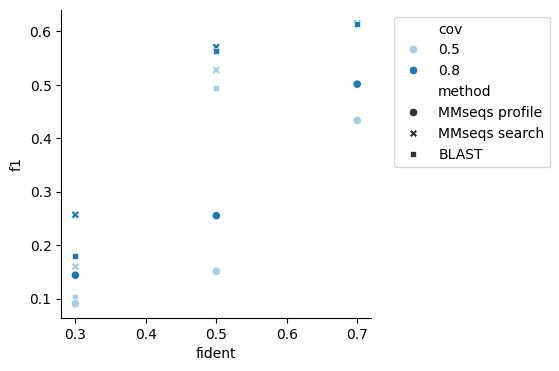

In [22]:
plt.subplots(figsize=(4,4))
sns.scatterplot(data=result_df, x='fident', y='f1', 
                style='method', hue='cov', palette='Paired')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()

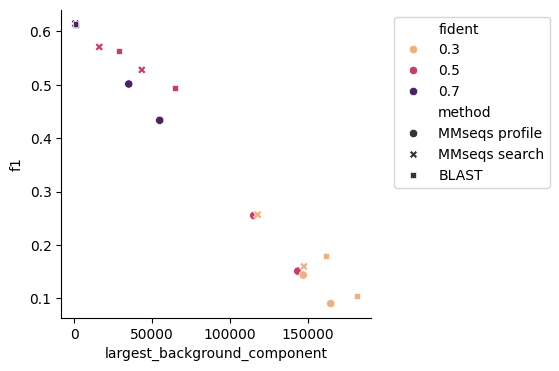

In [25]:
plt.subplots(figsize=(4,4))
sns.scatterplot(data=result_df, x='largest_background_component', y='f1', 
                style='method', hue='fident', palette='flare')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()

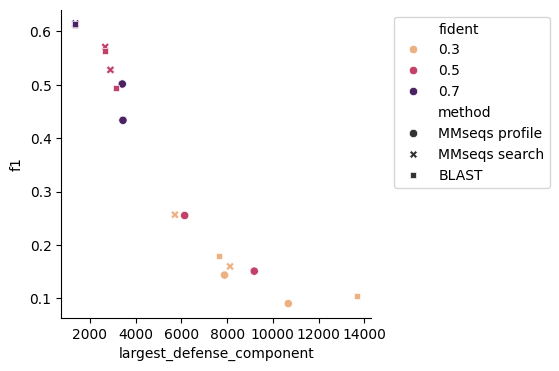

In [23]:
plt.subplots(figsize=(4,4))
sns.scatterplot(data=result_df, x='largest_defense_component', y='f1', 
                style='method', hue='fident', palette='flare')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()